In [7]:
from sklearn import neural_network
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from datetime import datetime
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

In [8]:
cleaned_data = pd.read_csv('clean_30min.csv',parse_dates = ['index10'], squeeze=True)
cleaned_data = cleaned_data.set_index(pd.DatetimeIndex(cleaned_data['index10'])).drop(['index10'], axis=1)

In [9]:
cleaned_data.head()

,Humidity,Temperature(C),GHI,Hour,Month,Output_power,previous
index10,,,,,,,
2020-09-20 20:00:00,78,9,0,20,9,0.0,0.0
2020-09-20 20:30:00,76,10,0,20,9,0.0,0.0
2020-09-20 21:00:00,75,10,0,21,9,0.0,0.0
2020-09-20 21:30:00,75,10,0,21,9,0.0,0.0
2020-09-20 22:00:00,75,10,0,22,9,0.0,0.0


## Train-test Split and Transformation 

In [10]:
x, y = cleaned_data.drop(['Output_power'],axis=1), cleaned_data['Output_power']
y = np.sqrt(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

## Feature Scaling

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Mape 

In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    convert inputs to numpy array.
    drop zeros in y_true. 
    calculate MAPE.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## KNN

In [13]:
from sklearn.neighbors import KNeighborsRegressor
model_knn = KNeighborsRegressor(n_neighbors=3, p = 1)
model_knn.fit(x_train, y_train)
y_pred_knn = model_knn.predict(x_test)

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

df_results = pd.DataFrame.from_dict({
    
    'MAPE': mean_absolute_percentage_error(y_test,y_pred_knn),
    'MAE': mean_absolute_error(y_test,y_pred_knn),
    #'MSE': mean_squared_error(y_test,y_pred_knn),
    'RMSE': math.sqrt(mean_squared_error(y_test,y_pred_knn)),
    #'nRMSE': (math.sqrt(mean_squared_error(y_test,y_pred_knn)))/y_test.mean(),
    'R-Squared': r2_score(y_test, y_pred_knn),
    'Predicted Standard Deviation of Test Set': np.std(y_pred_knn),
    'Actual Standard Deviation of Test Set': np.std(y_test),
    
},orient='index', columns=['Value'])
display(df_results)


,Value
MAPE,7.159395
MAE,0.040595
RMSE,0.124935
R-Squared,0.983527
Predicted Standard Deviation of Test Set,0.970330
Actual Standard Deviation of Test Set,0.973418


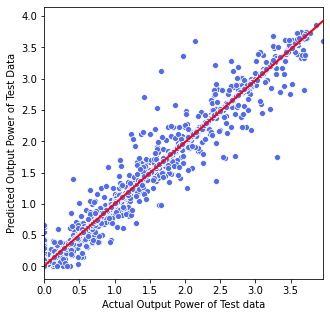

In [18]:
plt.figure(figsize=(5,5))
sns.scatterplot(y_test, y_pred_knn, color = '#516BEB')
sns.regplot(y_test,y_pred_knn,scatter=False,scatter_kws={'s': 100, 'alpha': 0.5, 'color': '#270082'},
            line_kws={'lw': 2, 'color': 'r'})

plt.xlabel("Actual Output Power of Test data")
plt.ylabel("Predicted Output Power of Test Data")
plt.show()

## Cross Validation for KNN 

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

crossvalidation = KFold(n_splits=10, random_state=42, shuffle=True)
scores_knn = cross_val_score(model_knn, x_train, y_train, scoring="r2", cv=crossvalidation, n_jobs=1)

print("Folds: " + str(len(scores_knn)) + ", MAE: " + str(np.mean(np.abs(scores_knn))) + ", STD:"+ str(np.std(scores_knn)))


Folds: 10, MAE: 0.9835603430741365, STD:0.002195752156792645


## XGBoost

In [15]:
# xgboost model
model_xgboost = XGBRegressor(n_estimators=450, learning_rate=0.1,subsample=.6, max_depth=10)
model_xgboost.fit(x_train, y_train)
y_pred_xgboost = model_xgboost.predict(x_test)

In [16]:
from sklearn.metrics import mean_absolute_error
df_results = pd.DataFrame.from_dict({
    
    'MAPE': mean_absolute_percentage_error(y_test,y_pred_xgboost),
    'MAE': mean_absolute_error(y_test,y_pred_xgboost),
    #'MSE': mean_squared_error(y_test,y_pred_xgboost),
    'RMSE': math.sqrt(mean_squared_error(y_test,y_pred_xgboost)),
    'R-Squared': r2_score(y_test, y_pred_xgboost),
    'Standard Deviation of predicted Test Set': np.std(y_pred_xgboost),
    'Actual Standard Deviation of actual Test Set': np.std(y_test),
    
   
    
},orient='index', columns=['Value'])
display(df_results)

,Value
MAPE,6.030773
MAE,0.036404
RMSE,0.115300
R-Squared,0.985970
Standard Deviation of predicted Test Set,0.971608
Actual Standard Deviation of actual Test Set,0.973418


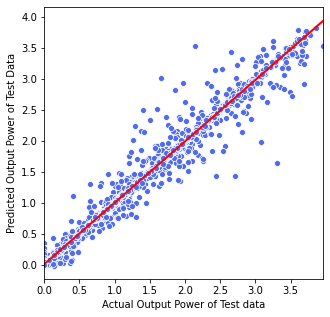

In [23]:
plt.figure(figsize=(5,5))
sns.scatterplot(y_test, y_pred_xgboost, color = '#516BEB')
sns.regplot(y_test,y_pred_xgboost,scatter=False,scatter_kws={'s': 100, 'alpha': 0.5, 'color': '#270082'},
            line_kws={'lw': 2, 'color': 'r'})

plt.xlabel("Actual Output Power of Test data")
plt.ylabel("Predicted Output Power of Test Data")

plt.show()

## Cross Validation of XGBoost

In [24]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

crossvalidation = KFold(n_splits=10, random_state=42, shuffle=True)
scores_xg = cross_val_score(model_xgboost, x_train, y_train, scoring="r2", cv=crossvalidation, n_jobs=1)

print("Folds: " + str(len(scores_xg)) + ", MAE: " + str(np.mean(np.abs(scores_xg))) + ", STD:"+ str(np.std(scores_xg)))

Folds: 10, MAE: 0.9872441992636845, STD:0.0022420184621117084


## MLP 

In [17]:
model_mlp = neural_network.MLPRegressor(hidden_layer_sizes=(80,80,80,80),
                                        activation='relu',
                                        solver='adam',
                                        learning_rate='invscaling',
                                        max_iter=150, 
                                        
                           )
model_mlp.fit(x_train, y_train)
y_pred_mlp = model_mlp.predict(x_test)

In [18]:
from sklearn.metrics import mean_absolute_error
df_results = pd.DataFrame.from_dict({
    
    'MAPE': mean_absolute_percentage_error(y_test,y_pred_mlp),
    'MAE': mean_absolute_error(y_test,y_pred_mlp),
    'RMSE': math.sqrt(mean_squared_error(y_test,y_pred_mlp)),
    'R-Squared': r2_score(y_test, y_pred_mlp),
    'Standard Deviation of predicted Test Set': np.std(y_pred_mlp),
    'Standard Deviation of actual Test Set': np.std(y_test),
    
},orient='index', columns=['Value'])
display(df_results)

,Value
MAPE,8.697891
MAE,0.045608
RMSE,0.114222
R-Squared,0.986231
Standard Deviation of predicted Test Set,0.968047
Standard Deviation of actual Test Set,0.973418


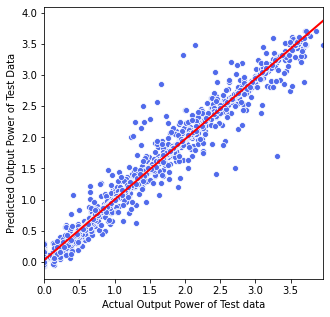

In [27]:
plt.figure(figsize=(5,5))
sns.scatterplot(y_test, y_pred_mlp, color = '#516BEB')
sns.regplot(y_test,y_pred_mlp,scatter=False,scatter_kws={'s': 100, 'alpha': 0.5, 'color': '#270082'},
            line_kws={'lw': 2, 'color': 'r'})

plt.xlabel("Actual Output Power of Test data")
plt.ylabel("Predicted Output Power of Test Data")
plt.show()

## Cross Validation MLP

In [28]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

crossvalidation = KFold(n_splits=10, random_state=42, shuffle=True)
scores_mlp = cross_val_score(model_mlp, x_train, y_train, scoring="r2", cv=crossvalidation, n_jobs=1)

print("Folds: " + str(len(scores_mlp)) + ", MAE: " + str(np.mean(np.abs(scores_mlp))) + ", STD:"+ str(np.std(scores_mlp)))

Folds: 10, MAE: 0.9861727533886528, STD:0.002015556467996834


## SVR 

In [19]:
# SVR model with sklearn
from sklearn.svm import SVR
model_svm = SVR(C =4, kernel='rbf', gamma= 0.8)
model_svm.fit(x_train, y_train.ravel())
y_pred_svm = model_svm.predict(x_test)

In [20]:
from sklearn.metrics import mean_absolute_error
df_results = pd.DataFrame.from_dict({
    
    'MAPE': mean_absolute_percentage_error(y_test,y_pred_svm),
    'MAE': mean_absolute_error(y_test,y_pred_svm),
    'RMSE': math.sqrt(mean_squared_error(y_test,y_pred_svm)),
    'R-Squared': r2_score(y_test, y_pred_svm),
    'Standard Deviation of predicted Test Set': np.std(y_pred_svm),
    'Standard Deviation of actual Test Set': np.std(y_test),
    
},orient='index', columns=['Value'])
display(df_results)

,Value
MAPE,10.808673
MAE,0.080197
RMSE,0.139085
R-Squared,0.979584
Standard Deviation of predicted Test Set,0.961823
Standard Deviation of actual Test Set,0.973418


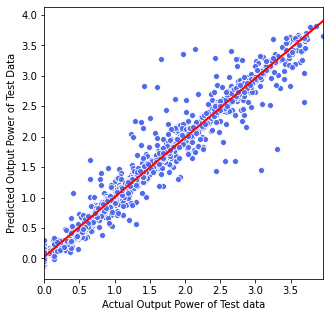

In [32]:
plt.figure(figsize=(5,5))
#plt.scatter(y_test, y_pred_xgboost)
sns.scatterplot(y_test, y_pred_svm,color = '#516BEB')

sns.regplot(y_test,y_pred_svm,scatter = False,scatter_kws = {'s': 100, 'alpha': 0.5, 'color': '#270082'},
            line_kws={'lw': 2, 'color': 'r'})
plt.xlabel("Actual Output Power of Test data")
plt.ylabel("Predicted Output Power of Test Data")
plt.show()

## Cross Validation of SVR

In [33]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

crossvalidation = KFold(n_splits=10, random_state=42, shuffle=True)
scores_svr = cross_val_score(model_svm, x_train, y_train, scoring="r2", cv=crossvalidation, n_jobs=1)

print("Folds: " + str(len(scores_svr)) + ", MAE: " + str(np.mean(np.abs(scores_svr))) + ", STD:"+ str(np.std(scores_svr)))

Folds: 10, MAE: 0.9822567833598651, STD:0.002091011932047836


## Random Forest

In [21]:
# Random Forest model with sklearn
from sklearn.ensemble import RandomForestRegressor
model_random_forest = RandomForestRegressor(n_estimators=350, max_features= 'log2')
model_random_forest.fit(x_train, y_train)
y_pred_random_forest = model_random_forest.predict(x_test)

In [22]:
from sklearn.metrics import mean_absolute_error
df_results = pd.DataFrame.from_dict({
    
    'MAPE': mean_absolute_percentage_error(y_test,y_pred_random_forest),
    'MAE': mean_absolute_error(y_test,y_pred_random_forest),
    #'MSE': mean_squared_error(y_test,y_pred_svm),
    'RMSE': math.sqrt(mean_squared_error(y_test,y_pred_random_forest)),
    'R-Squared': r2_score(y_test, y_pred_random_forest),
    'Predicted Standard Deviation of Test Set': np.std(y_pred_random_forest),
    'Actual Standard Deviation of Test Set': np.std(y_test),
    
},orient='index', columns=['Value'])
display(df_results)

,Value
MAPE,5.242355
MAE,0.032743
RMSE,0.110224
R-Squared,0.987178
Predicted Standard Deviation of Test Set,0.967389
Actual Standard Deviation of Test Set,0.973418


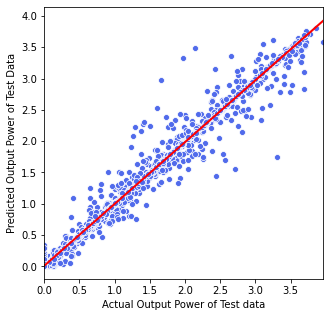

In [36]:
plt.figure(figsize=(5,5))
#plt.scatter(y_test, y_pred_xgboost)
sns.scatterplot(y_test, y_pred_random_forest,color = '#516BEB')

sns.regplot(y_test,y_pred_random_forest,scatter = False,scatter_kws = {'s': 100, 'alpha': 0.5, 'color': '#270082'},
            line_kws={'lw': 2, 'color': 'r'})
plt.xlabel("Actual Output Power of Test data")
plt.ylabel("Predicted Output Power of Test Data")
plt.show()

## Cross Validation RF

In [37]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

crossvalidation = KFold(n_splits=10, random_state=42, shuffle=True)
scores_rf = cross_val_score(model_random_forest, x_train, y_train, scoring="r2", cv=crossvalidation, n_jobs=1)

print("Folds: " + str(len(scores_rf)) + ", MAE: " + str(np.mean(np.abs(scores_rf))) + ", STD:"+ str(np.std(scores_rf)))

#neg_mean_absolute_error



Folds: 10, MAE: 0.9883333262645124, STD:0.0018923015801015463
